In [1]:
import glob
from tensorflow.keras import utils, applications as apps
from tensorflow.data import Dataset
from tensorflow.keras import layers, Model, losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import pathlib
import numpy as np
from tensorflow import Tensor
from skimage.io import imshow, imread
import glob
import pandas
import pathlib
from tensorflow.keras.utils import  plot_model
from matplotlib import pyplot
import skimage.util
from skimage import transform
import random

2023-03-14 12:02:38.700404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 12:02:38.798270: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-14 12:02:38.801077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 12:02:38.801086: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
def get_meniscus(label_names):
    menis_positions = []
    for label_name in label_names:
        with open(label_name) as lbl_handle:
            text1 = lbl_handle.readline()
        items = text1.split(' ')
        height_s = items[0]
        height = float(height_s)
        height = round(height)
        menis_positions.append(height)
    return np.array(menis_positions, dtype=np.int32)

In [3]:
image_names = glob.glob("framedata/**/*.png", recursive=True)
label_names = glob.glob("framedata/**/*.csv", recursive=True)
image_names.sort()
label_names.sort()

In [4]:
import math

class ImageSeq(Sequence):
    
    def __init__(self, image_names: list, label_names: list, batch_size: int=32):
        
        if len(image_names) != len(label_names):
            raise Exception("Length mismatch of images and labels")
        
        label_names.sort()
        image_names.sort()
        self.meniscus_heights = get_meniscus(label_names)
        self.image_names = image_names
        self.batch_size = batch_size
    
    def __len__(self):
        return math.ceil(len(self.image_names) / self.batch_size)
    
    def __getitem__(self, idx):
        labels = self.meniscus_heights[idx * self.batch_size : (idx + 1) * self.batch_size]
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        images = np.array([skimage.util.img_as_ubyte(
            transform.resize(
                imread(image_name), 
                (600, 100), 
                anti_aliasing=True
            )
        )[...,np.newaxis] for image_name in self.image_names[start:end]
                ])
        return images, labels

In [58]:
seq = ImageSeq(image_names, label_names, batch_size=32)

In [90]:
# from https://blog.paperspace.com/unet-architecture-image-segmentation/

def convolution_block(input_lay, filters=64):
    conv1 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(input_lay)
    bn1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(bn1)
    
    conv2 = layers.Conv2D(filters, kernel_size=(3,3), padding="same")(act1)
    bn2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(bn2)
    
    return act2

def encoder(input_lay, filters=64):
    enc1 = convolution_block(input_lay, filters)
    max_pool1 = layers.MaxPooling2D()(enc1)
    return enc1, max_pool1

def decoder(input_lay, skip_lay, filters=64):
    upsample = layers.Conv2DTranspose(filters, (2,2), strides=2, padding="same")(input_lay)
    connect_skip = layers.Concatenate()([upsample, skip_lay])
    out = convolution_block(connect_skip, filters)
    return out

def u_net(image_size):
    input1 = layers.Input(image_size)
    
    skip1, enc1 = encoder(input1, 64)
    skip2, enc2 = encoder(enc1, 64 * 2)
    skip3, enc3 = encoder(enc2, 64 * 4)
    skip4, enc4 = encoder(enc3, 64 * 8)
    
    conv_block = convolution_block(enc4, 64*16)
    
    dec1 = decoder(conv_block, skip4, 64 * 8)
    dec2 = decoder(dec1, skip3, 64 * 4)
    dec3 = decoder(dec2, skip2, 64 * 2)
    dec4 = decoder(dec3, skip1, 64)
    
    out = layers.Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(dec4)
    
    model = Model(input1, out)
    
    return model

In [92]:
inp = layers.Input(shape=[600,100,1])
res = layers.Rescaling(1.0/255)(inp)
#x = layers.Conv2D(filters=4, kernel_size=(3,3))(res)

skip1, enc1 = encoder(res, 64)

conv_block = convolution_block(enc1, 64 * 2)

dec1 = decoder(conv_block, skip1, 64)

f = layers.Flatten()(dec1)

out = layers.Dense(1)(f)

model = Model(inp, out)
model.compile(loss=losses.MeanSquaredError(), optimizer=Adam())
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 600, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 600, 100, 1)  0           ['input_22[0][0]']               
                                                                                                  
 conv2d_282 (Conv2D)            (None, 600, 100, 64  640         ['rescaling_14[0][0]']           
                                )                                                                 
                                                                                           

In [93]:
model.fit(seq)

3626/3626 [==============================] - 30598s 8s/step - loss: 9740.8516


In [94]:
items = seq[0]

In [95]:
ins = items[0]

In [96]:
outs = model(ins)

In [97]:
refs = items[1]

In [98]:
refs

array([115, 158, 158, 158, 159, 160, 160, 160, 163, 165, 165, 166, 166,
       116, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207,
       207, 207, 207, 207, 207, 207], dtype=int32)

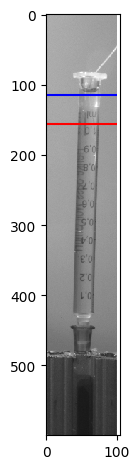

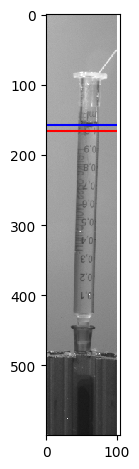

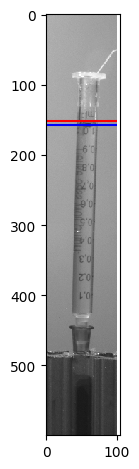

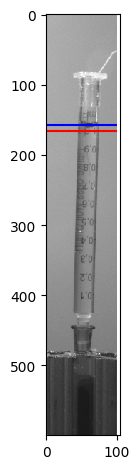

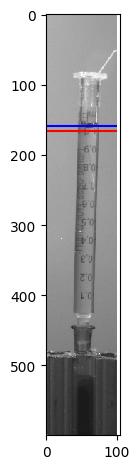

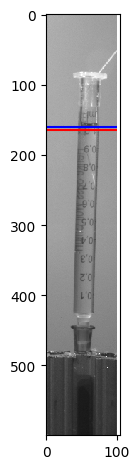

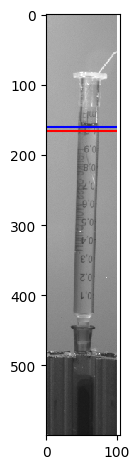

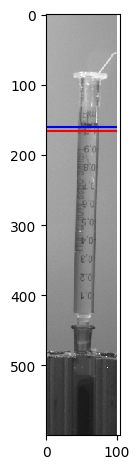

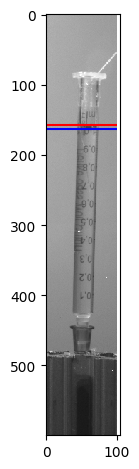

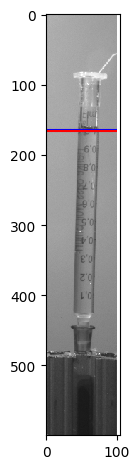

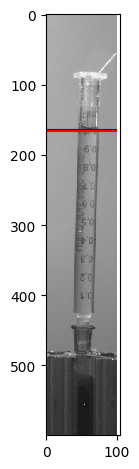

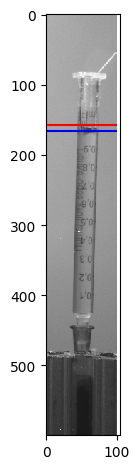

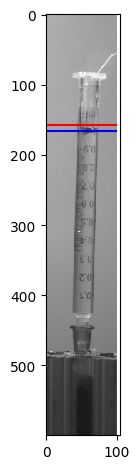

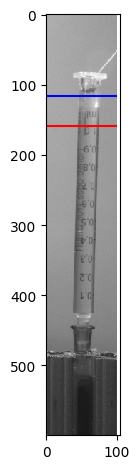

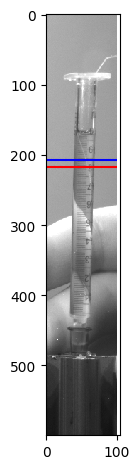

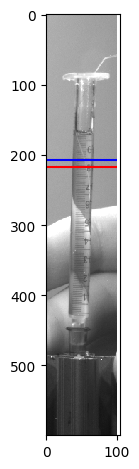

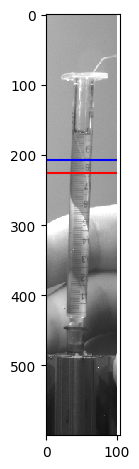

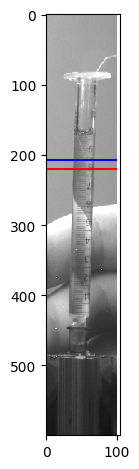

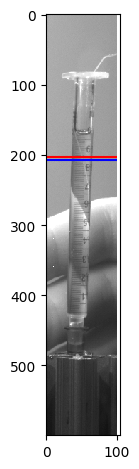

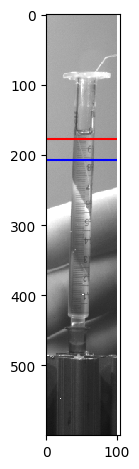

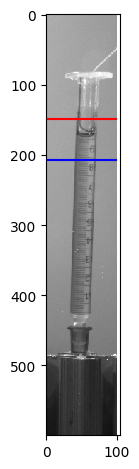

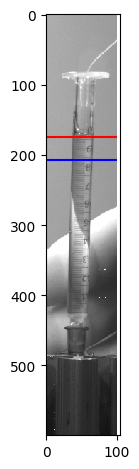

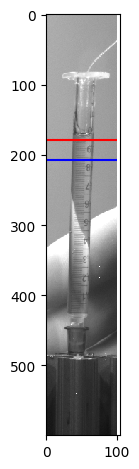

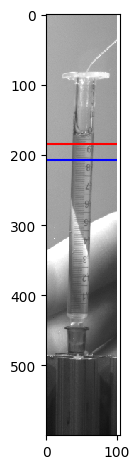

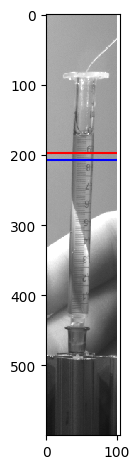

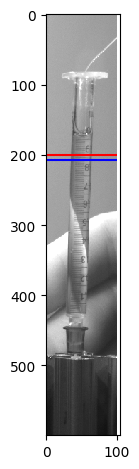

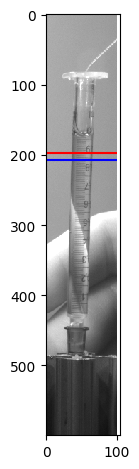

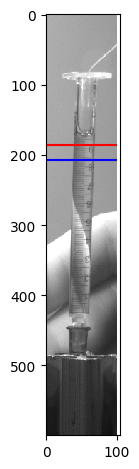

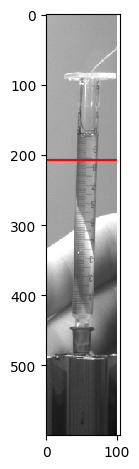

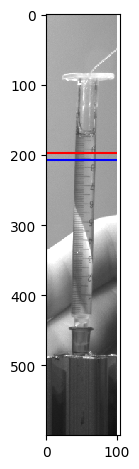

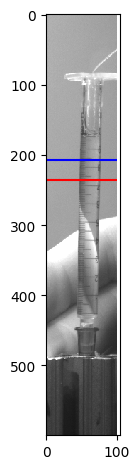

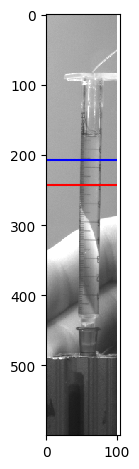

In [101]:
for i in range(32):
    imshow(ins[i,:,:,0]);pyplot.hlines(refs[i], 0, 100, color="blue");pyplot.hlines(outs[i], 0, 100, color="red");
    pyplot.show()

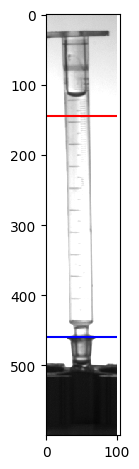

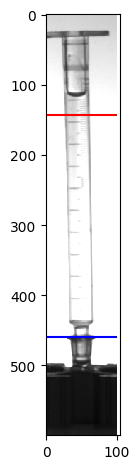

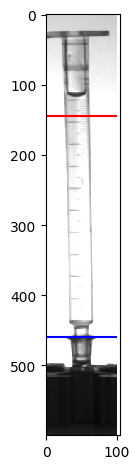

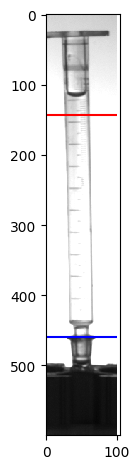

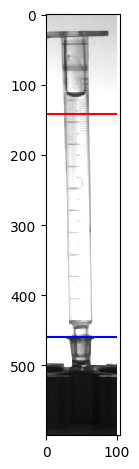

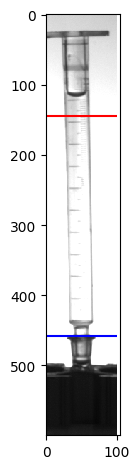

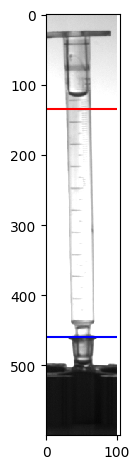

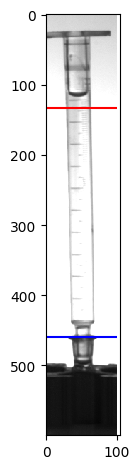

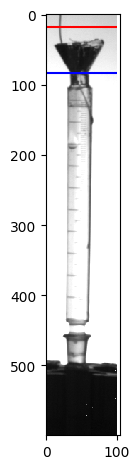

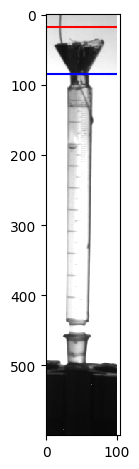

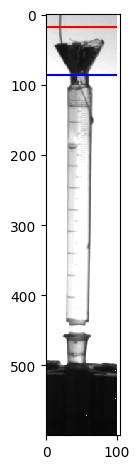

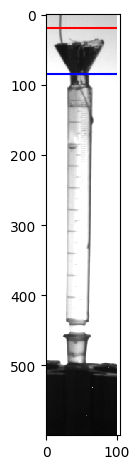

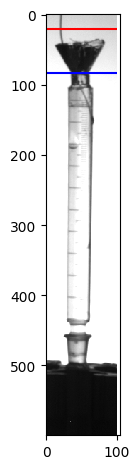

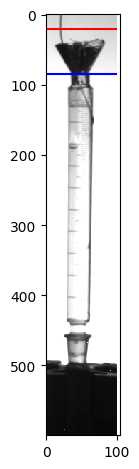

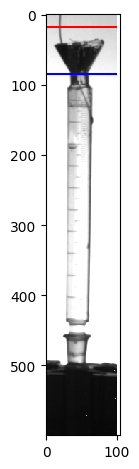

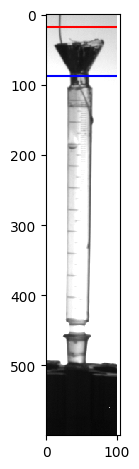

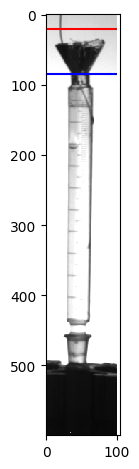

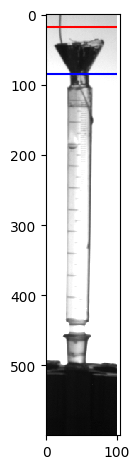

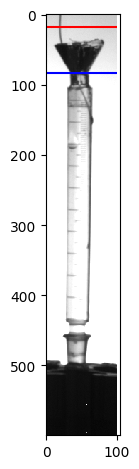

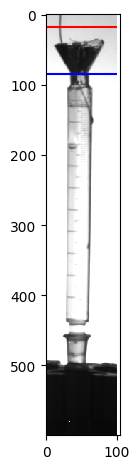

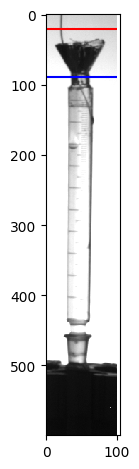

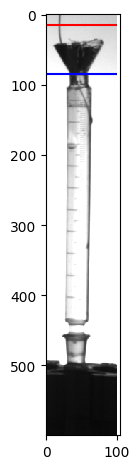

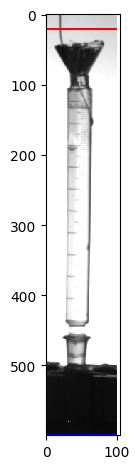

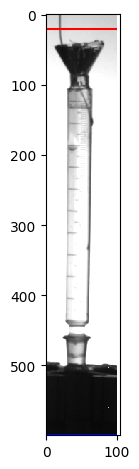

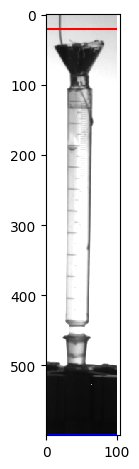

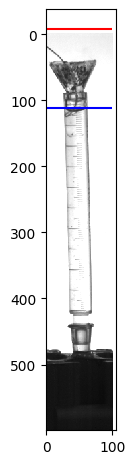

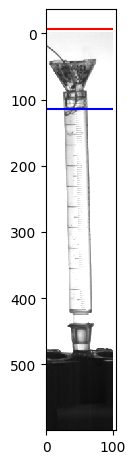

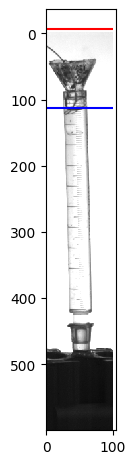

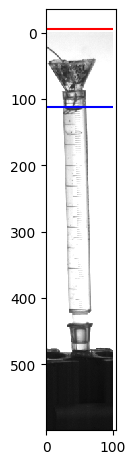

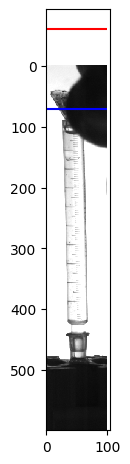

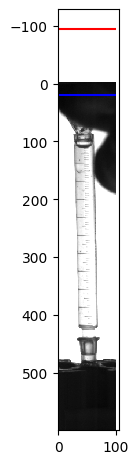

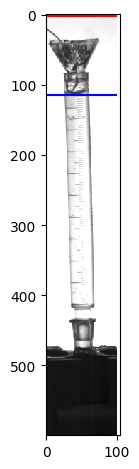

In [104]:
items2 = seq[500]
ins = items2[0]
outs = model(ins)
refs = items2[1]
for i in range(32):
    imshow(ins[i,:,:,0]);pyplot.hlines(refs[i], 0, 100, color="blue");pyplot.hlines(outs[i], 0, 100, color="red");
    pyplot.show()

In [105]:
outs

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[144.01259  ],
       [142.87993  ],
       [143.86644  ],
       [143.7065   ],
       [141.45078  ],
       [143.9801   ],
       [134.24045  ],
       [133.76945  ],
       [ 18.321505 ],
       [ 18.132267 ],
       [ 18.113008 ],
       [ 18.50889  ],
       [ 20.193527 ],
       [ 20.393335 ],
       [ 17.95468  ],
       [ 18.04914  ],
       [ 20.422909 ],
       [ 18.013288 ],
       [ 18.121687 ],
       [ 17.934484 ],
       [ 20.29685  ],
       [ 15.589549 ],
       [ 20.554417 ],
       [ 20.744646 ],
       [ 20.536175 ],
       [ -7.6067567],
       [ -6.3363214],
       [ -6.139706 ],
       [ -5.1445146],
       [-60.509525 ],
       [-93.90629  ],
       [  2.34374  ]], dtype=float32)>